# Detect Fake Account Vie Instagram
The idea of the notebook is to extract the data from the searched account and check the number of fake accounts on the following and the number of fake likes for post.

## Imports

In [2]:
# Imports
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import plot_confusion_matrix
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
%matplotlib inline

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier

from instagram_private_api import Client, ClientCompatPatch
import getpass

import random

# Data Interpretation and Splitting 

### The features Description:
 
- profile pic: does the user have a profile picture?
- nums/length username: ratio of numerical to alphabetical characters in the username
- fullname words: how many words are in the user's full name?
- nums/length fullname: ratio of numerical to alphabetical characters in the full name
- name==username: is the user's full name the same as the username?
- description length: how many characters is in the user's Instagram bio?
- external URL: does the user have an external URL linked to their profile?
- private: is the user private?
- posts: number of posts
- followers: number of people following the user
- follows: number of people the user follows
- fake: if the user is fake, fake=1, else fake=0

In [3]:
train = pd.read_csv("Dataset/train.csv")
test = pd.read_csv("Dataset/test.csv")

In [4]:
#Examine the training data.
train.head(5)

,profile pic,nums/length username,fullname words,nums/length fullname,name==username,description length,external URL,private,#posts,#followers,#follows,fake
0,1,0.27,0,0.0,0,53,0,0,32,1000,955,0
1,1,0.00,2,0.0,0,44,0,0,286,2740,533,0
2,1,0.10,2,0.0,0,0,0,1,13,159,98,0
3,1,0.00,1,0.0,0,82,0,0,679,414,651,0
4,1,0.00,2,0.0,0,0,0,1,6,151,126,0


In [45]:
train.describe()

,profile pic,nums/length username,fullname words,nums/length fullname,name==username,description length,external URL,private,#posts,#followers,#follows,fake
count,576.000000,576.000000,576.000000,576.000000,576.000000,576.000000,576.000000,576.000000,576.000000,5.760000e+02,576.000000,576.000000
mean,0.701389,0.163837,1.460069,0.036094,0.034722,22.623264,0.116319,0.381944,107.489583,8.530724e+04,508.381944,0.500000
std,0.458047,0.214096,1.052601,0.125121,0.183234,37.702987,0.320886,0.486285,402.034431,9.101485e+05,917.981239,0.500435
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
25%,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.900000e+01,57.500000,0.000000
50%,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000,1.505000e+02,229.500000,0.500000
75%,1.000000,0.310000,2.000000,0.000000,0.000000,34.000000,0.000000,1.000000,81.500000,7.160000e+02,589.500000,1.000000
max,1.000000,0.920000,12.000000,1.000000,1.000000,150.000000,1.000000,1.000000,7389.000000,1.533854e+07,7500.000000,1.000000


In [46]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 576 entries, 0 to 575
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   profile pic           576 non-null    int64  
 1   nums/length username  576 non-null    float64
 2   fullname words        576 non-null    int64  
 3   nums/length fullname  576 non-null    float64
 4   name==username        576 non-null    int64  
 5   description length    576 non-null    int64  
 6   external URL          576 non-null    int64  
 7   private               576 non-null    int64  
 8   #posts                576 non-null    int64  
 9   #followers            576 non-null    int64  
 10  #follows              576 non-null    int64  
 11  fake                  576 non-null    int64  
dtypes: float64(2), int64(10)
memory usage: 54.1 KB


In [47]:
train.shape

(576, 12)

In [48]:
#Examine the test data.
test.head(5)

,profile pic,nums/length username,fullname words,nums/length fullname,name==username,description length,external URL,private,#posts,#followers,#follows,fake
0,1,0.33,1,0.33,1,30,0,1,35,488,604,0
1,1,0.00,5,0.00,0,64,0,1,3,35,6,0
2,1,0.00,2,0.00,0,82,0,1,319,328,668,0
3,1,0.00,1,0.00,0,143,0,1,273,14890,7369,0
4,1,0.50,1,0.00,0,76,0,1,6,225,356,0


In [49]:
test.describe()

,profile pic,nums/length username,fullname words,nums/length fullname,name==username,description length,external URL,private,#posts,#followers,#follows,fake
count,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,1.200000e+02,120.000000,120.000000
mean,0.758333,0.179917,1.550000,0.071333,0.041667,27.200000,0.100000,0.308333,82.866667,4.959472e+04,779.266667,0.500000
std,0.429888,0.241492,1.187116,0.209429,0.200664,42.588632,0.301258,0.463741,230.468136,3.816126e+05,1409.383558,0.502096
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,1.000000,0.000000
25%,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,6.725000e+01,119.250000,0.000000
50%,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2.165000e+02,354.500000,0.500000
75%,1.000000,0.330000,2.000000,0.000000,0.000000,45.250000,0.000000,1.000000,58.250000,5.932500e+02,668.250000,1.000000
max,1.000000,0.890000,9.000000,1.000000,1.000000,149.000000,1.000000,1.000000,1879.000000,4.021842e+06,7453.000000,1.000000


In [50]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   profile pic           120 non-null    int64  
 1   nums/length username  120 non-null    float64
 2   fullname words        120 non-null    int64  
 3   nums/length fullname  120 non-null    float64
 4   name==username        120 non-null    int64  
 5   description length    120 non-null    int64  
 6   external URL          120 non-null    int64  
 7   private               120 non-null    int64  
 8   #posts                120 non-null    int64  
 9   #followers            120 non-null    int64  
 10  #follows              120 non-null    int64  
 11  fake                  120 non-null    int64  
dtypes: float64(2), int64(10)
memory usage: 11.4 KB


In [51]:
test.shape

(120, 12)

In [52]:
#Check for NULL values
print(train.isna().values.any().sum())
print(test.isna().values.any().sum())

0
0


<AxesSubplot:>

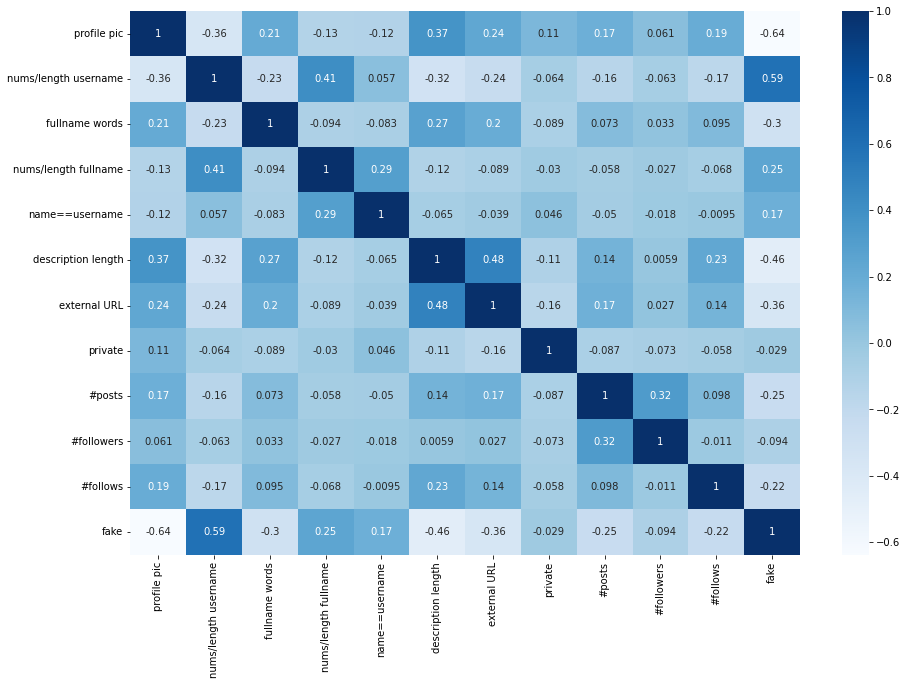

In [53]:
#To check for significantly relevant features, create a correlation matrix for the features in the training data.
fig, ax = plt.subplots(figsize=(15,10))  
corr=train.corr()
sns.heatmap(corr, annot=True,cmap="Blues")

In [54]:
corr = train.corr()['fake'].abs().sort_values(ascending = False)
corr

fake                    1.000000
profile pic             0.637315
nums/length username    0.587687
description length      0.460825
external URL            0.362809
fullname words          0.298793
nums/length fullname    0.246782
#posts                  0.245355
#follows                0.224835
name==username          0.170695
#followers              0.093689
private                 0.028586
Name: fake, dtype: float64

## Removeing useless data

In [5]:
train['High_followers'] = np.where(train['#followers']> 120, 1, 0) # 1 means the account followers higher than 120, and 0 otherwise.
train['High_follows'] = np.where(train['#follows']> 200, 1, 0) # 1 means the account follows higher than 200, and 0 otherwise.
train['High_posts'] = np.where(train['#posts']> 10, 1, 0) # 1 means the account posts higher than 10, and 0 otherwise.

test['High_followers'] = np.where(test['#followers']> 120, 1, 0) # 1 means the account followers higher than 120, and 0 otherwise.
test['High_follows'] = np.where(test['#follows']> 200, 1, 0) # 1 means the account follows higher than 200, and 0 otherwise.
test['High_posts'] = np.where(test['#posts']> 10, 1, 0) # 1 means the account posts higher than 10, and 0 otherwise.

<AxesSubplot:>

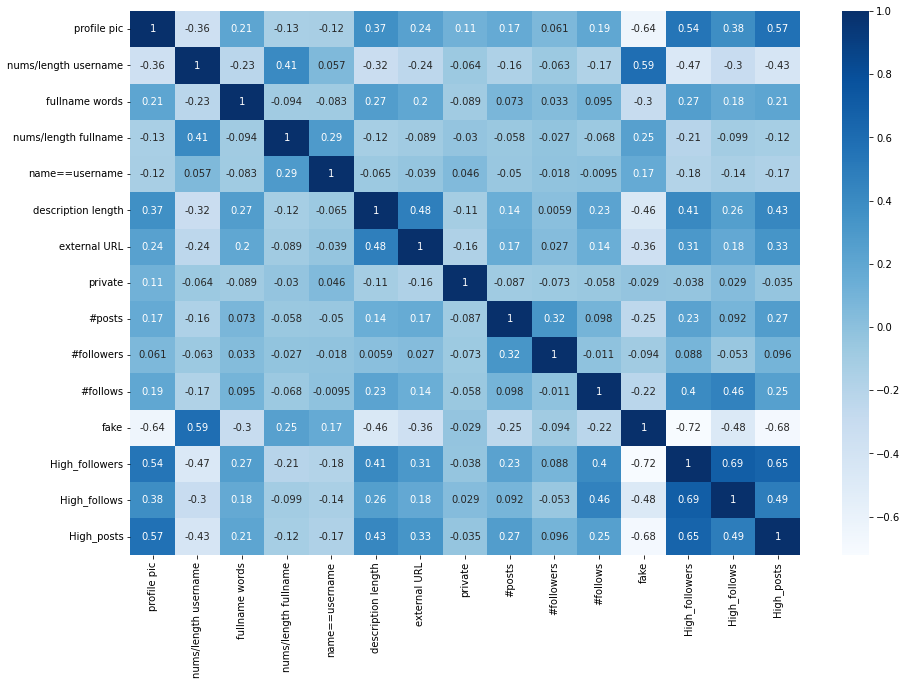

In [56]:
#To check for significantly relevant features, create a correlation matrix for the features in the training data.
fig, ax = plt.subplots(figsize=(15,10))  
corr=train.corr()
sns.heatmap(corr, annot=True,cmap="Blues")

In [57]:
corr = train.corr()['fake'].abs().sort_values(ascending = False)
corr

fake                    1.000000
High_followers          0.720319
High_posts              0.680818
profile pic             0.637315
nums/length username    0.587687
High_follows            0.476180
description length      0.460825
external URL            0.362809
fullname words          0.298793
nums/length fullname    0.246782
#posts                  0.245355
#follows                0.224835
name==username          0.170695
#followers              0.093689
private                 0.028586
Name: fake, dtype: float64

## Split Data

In [6]:
#Split the training set into data and labels

# Labels
train_Y = train.fake
train_Y = pd.DataFrame(train_Y)

# Data
train_X = train.drop(columns='fake')

train_Y.head()

,fake
0,0
1,0
2,0
3,0
4,0


In [7]:
train_X.head()

,profile pic,nums/length username,fullname words,nums/length fullname,name==username,description length,external URL,private,#posts,#followers,#follows,High_followers,High_follows,High_posts
0,1,0.27,0,0.0,0,53,0,0,32,1000,955,1,1,1
1,1,0.00,2,0.0,0,44,0,0,286,2740,533,1,1,1
2,1,0.10,2,0.0,0,0,0,1,13,159,98,1,0,1
3,1,0.00,1,0.0,0,82,0,0,679,414,651,1,1,1
4,1,0.00,2,0.0,0,0,0,1,6,151,126,1,0,0


In [8]:
#Split the test set into data and labels

# Labels
test_Y = test.fake
test_Y = pd.DataFrame(test_Y)

# Data
test_X = test.drop(columns='fake')
test_Y

,fake
0,0
1,0
2,0
3,0
4,0
...,...
115,1
116,1
117,1
118,1


In [61]:
test_X.head()

,profile pic,nums/length username,fullname words,nums/length fullname,name==username,description length,external URL,private,#posts,#followers,#follows,High_followers,High_follows,High_posts
0,1,0.33,1,0.33,1,30,0,1,35,488,604,1,1,1
1,1,0.00,5,0.00,0,64,0,1,3,35,6,0,0,0
2,1,0.00,2,0.00,0,82,0,1,319,328,668,1,1,1
3,1,0.00,1,0.00,0,143,0,1,273,14890,7369,1,1,1
4,1,0.50,1,0.00,0,76,0,1,6,225,356,1,1,0


In [62]:
train.head()

,profile pic,nums/length username,fullname words,nums/length fullname,name==username,description length,external URL,private,#posts,#followers,#follows,fake,High_followers,High_follows,High_posts
0,1,0.27,0,0.0,0,53,0,0,32,1000,955,0,1,1,1
1,1,0.00,2,0.0,0,44,0,0,286,2740,533,0,1,1,1
2,1,0.10,2,0.0,0,0,0,1,13,159,98,0,1,0,1
3,1,0.00,1,0.0,0,82,0,0,679,414,651,0,1,1,1
4,1,0.00,2,0.0,0,0,0,1,6,151,126,0,1,0,0


# Comparing Classification Models

In [9]:
# Baseline classifier
fakes = len([i for i in train.fake if i==1])
auth = len([i for i in train.fake if i==0])
fakes, auth

# classify everything as fake
pred = [1 for i in range(len(test_X))]
pred = np.array(pred)
print("Baseline Accuracy: " + str(accuracy_score(pred, test_Y)))

Baseline Accuracy: 0.5


In [21]:
confColors = ['#EC0351', '#8a3ab9', '#bc2a8d', '#cd486b','#e95950', '#fbad50','#fccc63', '#4c68d7', '#333ADD']
def conf_matrix(actual, predicted):
    cm = confusion_matrix(actual, predicted)
    sns.heatmap(cm, xticklabels=['predicted_negative', 'predicted_positive'], 
                yticklabels=['actual_negative', 'actual_positive'], annot=True,
                fmt='d', annot_kws={'fontsize':20}, cmap=confColors);

    true_neg, false_pos = cm[0]
    false_neg, true_pos = cm[1]

    accuracy = round((true_pos + true_neg) / (true_pos + true_neg + false_pos + false_neg),3)
    precision = round((true_pos) / (true_pos + false_pos),3)
    recall = round((true_pos) / (true_pos + false_neg),3)
    f1 = round(2 * (precision * recall) / (precision + recall),3)

    cm_results = [accuracy, precision, recall, f1]
    return cm_results

## Logistic Regression

In [31]:
lm = LogisticRegression()

# Train the model
model1_LR = lm.fit(train_X, train_Y)

# Make a prediction
lm_predict = model1_LR.predict(test_X)

C:\anaconda\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [32]:
# Compute the accuracy of the model
accLR = accuracy_score(lm_predict, test_Y)
print("Logistic Regression accuracy: " + str(accLR))
# Precision = TruePositive (TP)/ (TruePositive (TP) + FalsePositive (FP) 
print('precision: ',precision_score(model1_LR.predict(test_X),test_Y))
# Recall = TruePositive (TP)/ (TruePositive (TP) + FalseNegative (FN) 
print('recall: ', recall_score(model1_LR.predict(test_X),test_Y))
# F1 − Score = 2 × (Precision × Recall)/ (Precision + Recall)
F1LR = f1_score(model1_LR.predict(test_X),test_Y)
print('F1: ',F1LR)

Logistic Regression accuracy: 0.95
precision:  0.95
recall:  0.95
F1:  0.9500000000000001


[0.95, 0.95, 0.95, 0.95]

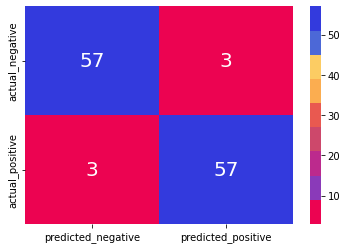

In [33]:
#confusion_matrix
conf_matrix(test_Y,lm_predict) 

## KNN Classifier

C:\anaconda\lib\site-packages\sklearn\neighbors\_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\anaconda\lib\site-packages\sklearn\neighbors\_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\anaconda\lib\site-packages\sklearn\neighbors\_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\anaconda\lib\site-packages\sklearn\neighbors\_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fi

The highest accuracy obtained using KNN is 0.8666666666666667 achieved by a value of n=7


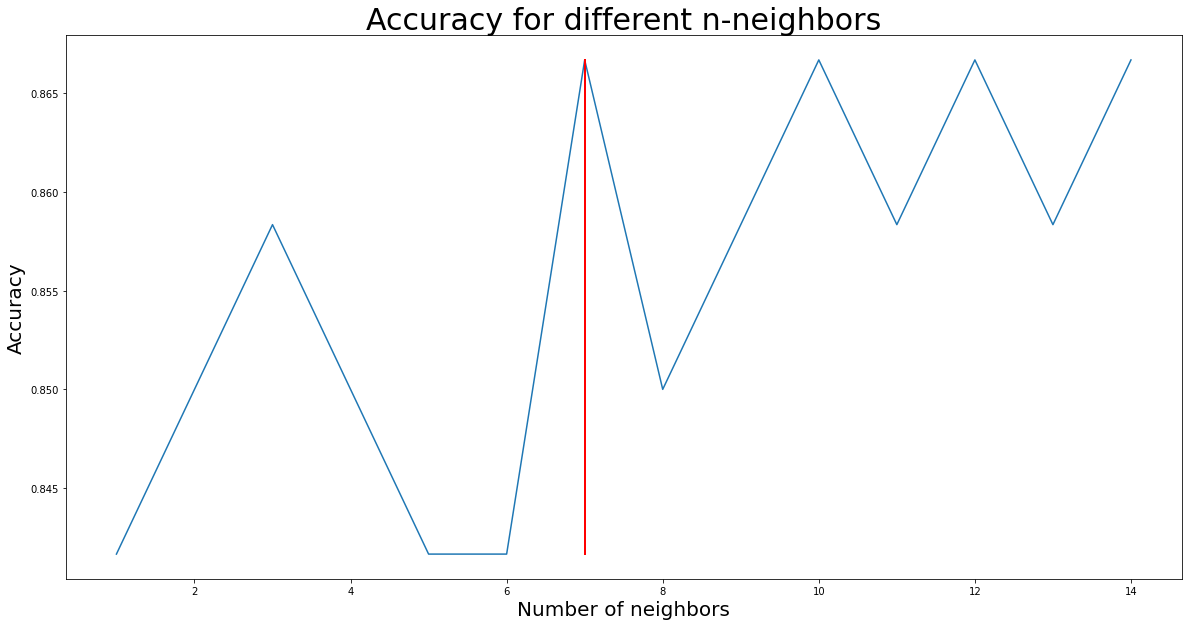

In [34]:
accuracies = []

# Compare the accuracies of using the KNN classifier with different number of neighbors
for i in range(1,15):
    knn = KNeighborsClassifier(n_neighbors=i)
    model2_KNN = knn.fit(train_X,train_Y)
    knn_predict = model2_KNN.predict(test_X)
    accuracy = accuracy_score(knn_predict,test_Y)
    accuracies.append(accuracy)

max_acc = (0, 0)
for i in range(1, 15):
    if accuracies[i-1] > max_acc[1]:
        max_acc = (i, accuracies[i-1])

max_acc

f, ax = plt.subplots(figsize=(20,10))
plt.plot([i for i in range(1,15)], accuracies)
plt.plot([7 for i in range(len(accuracies))], accuracies, color='red')
plt.title("Accuracy for different n-neighbors", size=30)
plt.xlabel('Number of neighbors', fontsize=20)
plt.ylabel('Accuracy', fontsize=20)

print("The highest accuracy obtained using KNN is " + str(max_acc[1]) + " achieved by a value of n=" + str(max_acc[0]))

C:\anaconda\lib\site-packages\sklearn\neighbors\_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


accuracy: 0.8666666666666667
precision: 0.8333333333333334
recall: 0.8928571428571429
F1: 0.8620689655172413


[0.867, 0.893, 0.833, 0.862]

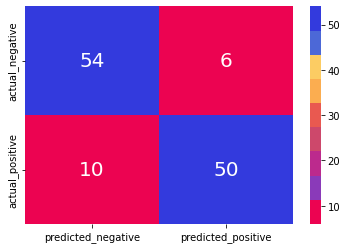

In [35]:
#confusion_matrix
knn = KNeighborsClassifier(n_neighbors=max_acc[0])
knn = knn.fit(train_X,train_Y)
knn_predict = knn.predict(test_X)
knn_acc = accuracy_score(knn_predict,test_Y)
# Accuracy 
print('accuracy: {}'.format(knn_acc))
# Precision 
perKnn=precision_score(knn_predict,test_Y)
print('precision: {}'.format(perKnn))
# Recall
reKnn = recall_score(knn_predict,test_Y)
print('recall: {}'.format(reKnn) )
# F1 − Score 
F1KNN = f1_score(knn_predict,test_Y)
print('F1: {}'.format(F1KNN))
conf_matrix(test_Y, knn_predict) 

## Decision Tree Classifier

In [36]:
DT = DecisionTreeClassifier()

# Train the model
model3_DT = DT.fit(train_X, train_Y)

# Make a prediction
DT_predict = model3_DT.predict(test_X)

In [37]:
# Compute the accuracy of the model
acc = accuracy_score(DT_predict, test_Y)
print("Decision Tree accuracy: " + str(acc))
# Precision 
print('precision: ',precision_score(model3_DT.predict(test_X),test_Y))
# Recall
print('recall: ', recall_score(model3_DT.predict(test_X),test_Y))
# F1 − Score 
F1DS = f1_score(model3_DT.predict(test_X),test_Y)
print('F1: ',F1DS)

Decision Tree accuracy: 0.8833333333333333
precision:  0.85
recall:  0.9107142857142857
F1:  0.8793103448275861


[0.883, 0.911, 0.85, 0.879]

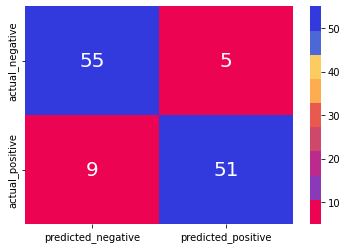

In [38]:
#confusion_matrix
conf_matrix(test_Y, DT_predict) 

## Random Forest Classifier

In [39]:
rfc = RandomForestClassifier()

# Train the model
model4_rfc = rfc.fit(train_X, train_Y)

# Make a prediction
rfc_predict = model4_rfc.predict(test_X)

C:\Users\AZOOZA~1\AppData\Local\Temp/ipykernel_29428/2940889855.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model4_rfc = rfc.fit(train_X, train_Y)


In [40]:
# Compute the accuracy of the model
acc = accuracy_score(rfc_predict, test_Y)
print("Random Forest accuracy: " + str(acc))
# Precision 
print('precision: ',precision_score(model4_rfc.predict(test_X),test_Y))
# Recall
print('recall: ',recall_score(model4_rfc.predict(test_X),test_Y))
# F1 − Score 
F1RF = f1_score(model4_rfc.predict(test_X),test_Y)
print('F1: ',F1RF)

Random Forest accuracy: 0.925
precision:  0.9166666666666666
recall:  0.9322033898305084
F1:  0.9243697478991596


[0.925, 0.932, 0.917, 0.924]

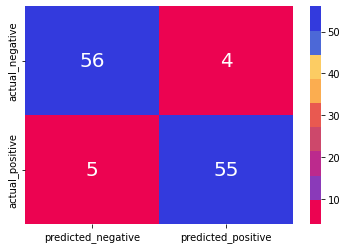

In [41]:
#confusion_matrix
conf_matrix(test_Y, rfc_predict) 

# Getting Data from Instagram 

In [207]:
def login():
    username = input("Enter your username: ")
    password = getpass.getpass("Enter your password: ")
    api = Client(username, password)
    return api

api = login()

username: azooz_alkhonain
password: ········


In [208]:
def get_ID(username):
    return api.username_info(username)['user']['pk']

In [215]:
userId_entry = input('Enter username you want to search for: ')
userID = get_ID(userId_entry)

Enter username you want to search for: aljoud_kn1


In [216]:
#The API needs some sort of rank to query followers, posts, etc.
rank = api.generate_uuid()

In [217]:
#Get the user's list follower usernames 
def get_followers(userID, rank):
    followers = []
    next_max_id = True
    
    while next_max_id:
        if next_max_id == True: next_max_id=''
        f = api.user_followers(userID, rank, max_id=next_max_id)
        followers.extend(f.get('users', []))
        next_max_id = f.get('next_max_id', '')
    
    user_fer = [dic['username'] for dic in followers]
    
    return user_fer

In [218]:
followers = get_followers(userID, rank)

In [219]:
#Check the number of followers 
len(followers)

209

# Preparing the Data

In [220]:
# The first follower and the last username on the list
print(followers[0])
print(followers[-1])

azooz_alkhonain
lamaalmuqrin13


In [222]:
# This will get the information on a first user
print('The account is: ', followers[0])
informations = api.user_info(get_ID(followers[0]))['user']
print(informations)
# Check what information is available for one particular user
informations.keys()

The account is:  azooz_alkhonain
{'pk': 362371432, 'username': 'azooz_alkhonain', 'full_name': 'عبدالعزيز', 'is_private': True, 'profile_pic_url': 'https://instagram.fruh4-5.fna.fbcdn.net/v/t51.2885-19/11184625_677507259020082_569961313_a.jpg?_nc_ht=instagram.fruh4-5.fna.fbcdn.net&_nc_ohc=QNC8tI5gVNEAX8kCOWv&edm=AEF8tYYBAAAA&ccb=7-4&oh=e4ef7d96d2d2b85916d5de5bf41880c5&oe=6186F0C2&_nc_sid=a9513d', 'is_verified': False, 'follow_friction_type': 0, 'has_anonymous_profile_picture': False, 'media_count': 0, 'geo_media_count': 0, 'follower_count': 83, 'following_count': 65, 'following_tag_count': 0, 'biography': 'Snap:azooz_alkhonain', 'can_link_entities_in_bio': True, 'biography_with_entities': {'raw_text': 'Snap:azooz_alkhonain', 'entities': []}, 'external_url': '', 'show_fb_link_on_profile': False, 'has_biography_translation': True, 'can_boost_post': False, 'can_see_organic_insights': False, 'show_insights_terms': False, 'can_convert_to_business': True, 'can_create_sponsor_tags': False, 'i

dict_keys(['pk', 'username', 'full_name', 'is_private', 'profile_pic_url', 'is_verified', 'follow_friction_type', 'has_anonymous_profile_picture', 'media_count', 'geo_media_count', 'follower_count', 'following_count', 'following_tag_count', 'biography', 'can_link_entities_in_bio', 'biography_with_entities', 'external_url', 'show_fb_link_on_profile', 'has_biography_translation', 'can_boost_post', 'can_see_organic_insights', 'show_insights_terms', 'can_convert_to_business', 'can_create_sponsor_tags', 'is_allowed_to_create_standalone_nonprofit_fundraisers', 'is_allowed_to_create_standalone_personal_fundraisers', 'can_create_new_standalone_fundraiser', 'can_create_new_standalone_personal_fundraiser', 'can_be_tagged_as_sponsor', 'can_see_support_inbox', 'can_see_support_inbox_v1', 'total_igtv_videos', 'has_videos', 'total_clips_count', 'has_saved_items', 'total_ar_effects', 'reel_auto_archive', 'is_profile_action_needed', 'usertags_count', 'usertag_review_enabled', 'is_needy', 'is_interest_

In [223]:
#We have almost all of the features we need to create a user data point for prediction,
#but we still have to filter and extract it, as well as do some computations.

def get_data(info):
    
    """Extract the information from the returned JSON.
    
    This function will return the following array:
        data = [profile pic,
                nums/length username,
                full name words,
                nums/length full name,
                name==username,
                description length,
                external URL,
                private,
                #posts,
                #followers,
                #followings]
    """
    
    data = []
    
    # Below is code to gathered from the above account and convert them to meet our dataset
    
    # Does the user have a profile photo?
    profile_pic = not info['has_anonymous_profile_picture']
    if profile_pic == True:
        profile_pic = 1
    else:
        profile_pic = 0
    data.append(profile_pic)
    
    # Ratio of number of numerical chars in username to its length
    username = info['username']
    uname_ratio = len([x for x in username if x.isdigit()]) / float(len(username))
    data.append(uname_ratio)
    
    # Full name in word tokens
    full_name = info['full_name']
    fname_tokens = len(full_name.split(' '))
    data.append(fname_tokens)
    
    # Ratio of number of numerical characters in full name to its length
    if len(full_name) == 0:
        fname_ratio = 0
    else:
        fname_ratio = len([x for x in full_name if x.isdigit()]) / float(len(full_name))
    data.append(fname_ratio)
    
    # Is name == username?
    name_eq_uname = (full_name == username)
    if name_eq_uname == True:
        name_eq_uname = 1
    else:
        name_eq_uname = 0
    data.append(name_eq_uname)
    
    # Number of characters on user bio 
    bio_length = len(info['biography'])
    data.append(bio_length)
    
    # Does the user have an external URL?
    ext_url = info['external_url'] != ''
    if ext_url == True:
        ext_url = 1
    else:
        ext_url = 0
    data.append(ext_url)
    
    # Is the user private or no?
    private = info['is_private']
    if private == True:
        private = 1
    else:
        private = 0
    data.append(private)
    
    # Number of posts
    posts = info['media_count']
    data.append(posts)
    
    # Number of followers
    followers = info['follower_count']
    data.append(followers)
    
    # Number of followings
    followings = info['following_count']
    data.append(followings)
    
  
    return data

In [224]:
# Check if the function returns as expected
get_data(informations)

[1, 0.0, 1, 0.0, 0, 20, 0, 1, 0, 83, 65]

In [225]:
#the Instagram Private API has a very limited number of API calls per hour so we will not be able to analyze all of the user's followers.

#for that, we took statistics and learned that random sampling is useful to cull
#a smaller sample size from a larger population and use it to research and make generalizations about the larger group.

#This will allow us to make user authenticity approximations despite the API limitations
#and still have data that is representative of the user's followers.

In [226]:
# Get a random sample of 50 followers
random_followers = random.sample(followers, 50)

In [227]:
#Get user information for each follower
f_infos = []

for follower in random_followers:
    info = api.user_info(get_ID(follower))['user']
    f_infos.append(info)

In [228]:
f_table = []

for info in f_infos:
    f_table.append(get_data(info))
    
f_table

[[0, 0.42857142857142855, 2, 0.0, 0, 0, 0, 0, 0, 20, 55],
 [1, 0.3333333333333333, 1, 0.0, 0, 0, 0, 0, 0, 33, 203],
 [1, 0.5714285714285714, 2, 0.0, 0, 4, 0, 0, 50, 1098, 337],
 [1, 0.0, 2, 0.0, 0, 0, 0, 1, 0, 32, 49],
 [1, 0.16666666666666666, 1, 0, 0, 0, 0, 1, 0, 3, 14],
 [1, 0.125, 3, 0.0, 0, 67, 1, 0, 102, 793, 1384],
 [0, 0.4444444444444444, 1, 0.0, 0, 1, 0, 0, 0, 83, 38],
 [1, 0.25, 1, 0.2222222222222222, 0, 29, 0, 0, 0, 77, 42],
 [1, 0.16666666666666666, 1, 0.0, 0, 0, 0, 1, 0, 361, 23],
 [1, 0.25, 1, 0.0, 0, 63, 0, 1, 9, 178, 400],
 [1, 0.0, 1, 0.0, 0, 95, 0, 1, 28, 92, 193],
 [1, 0.0, 1, 0.0, 0, 68, 1, 1, 0, 39, 476],
 [1, 0.23529411764705882, 1, 0.0, 0, 132, 1, 0, 677, 1741, 1087],
 [1, 0.06666666666666667, 2, 0.0, 0, 0, 0, 0, 15, 30, 24],
 [0, 0.14285714285714285, 1, 0.42857142857142855, 0, 0, 0, 0, 1, 140, 591],
 [1, 0.14285714285714285, 1, 0, 0, 150, 1, 0, 350, 572, 2814],
 [1, 0.14285714285714285, 2, 0.0, 0, 85, 0, 0, 3, 71, 63],
 [1, 0.0, 1, 0.0, 0, 120, 0, 0, 385, 337, 2

In [229]:
# Create a dataframe

test_data = pd.DataFrame(f_table,
                         columns = ['profile pic', 
                                    'nums/length username', 
                                    'fullname words',
                                    'nums/length fullname',
                                    'name==username',
                                    'description length',
                                    'external URL',
                                    'private',
                                    '#posts',
                                    '#followers',
                                    '#follows'])

test_data['High_followers'] = np.where(test_data['#followers']> 120, 1, 0) # 1 means the account followers higher than 120, and 0 otherwise.
test_data['High_follows'] = np.where(test_data['#follows']> 200, 1, 0) # 1 means the account follows higher than 200, and 0 otherwise.
test_data['High_posts'] = np.where(test_data['#posts']> 10, 1, 0) # 1 means the account posts higher than 10, and 0 otherwise.

test_data

,profile pic,nums/length username,fullname words,nums/length fullname,name==username,description length,external URL,private,#posts,#followers,#follows,High_followers,High_follows,High_posts
0,0,0.428571,2,0.000000,0,0,0,0,0,20,55,0,0,0
1,1,0.333333,1,0.000000,0,0,0,0,0,33,203,0,1,0
2,1,0.571429,2,0.000000,0,4,0,0,50,1098,337,1,1,1
3,1,0.000000,2,0.000000,0,0,0,1,0,32,49,0,0,0
4,1,0.166667,1,0.000000,0,0,0,1,0,3,14,0,0,0
5,1,0.125000,3,0.000000,0,67,1,0,102,793,1384,1,1,1
6,0,0.444444,1,0.000000,0,1,0,0,0,83,38,0,0,0
7,1,0.250000,1,0.222222,0,29,0,0,0,77,42,0,0,0
8,1,0.166667,1,0.000000,0,0,0,1,0,361,23,1,0,0
9,1,0.250000,1,0.000000,0,63,0,1,9,178,400,1,1,0


# The prediction

In [251]:
#In part 2, we have compared the different classifiers
#and found that the Random Forest Classifier had the highest accuracy at 92.5%.
#Therefore, we are going to use this classifier to make the prediction.

rfc = RandomForestClassifier()

# Train the model
# We've done this in Part 2 but I'm redoing it here for coherence ☺️
rfc_model = rfc.fit(train_X, train_Y)

C:\Users\AZOOZA~1\AppData\Local\Temp/ipykernel_13272/2052750926.py:9: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



In [252]:
rfc_labels = rfc_model.predict(test_data)
rfc_labels

array([1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0,
       1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0,
       0, 1, 1, 0, 1, 0], dtype=int64)

In [257]:
# Calculate the number of fake accounts in the random sample of 50 followers
no_fakes = len([x for x in rfc_labels if x==1])
print(no_fakes,' accounts were fake of the 50 sample')

30  accounts were fake of the 50 sample


In [275]:
auth = (len(random_followers) - no_fakes) * 100 / len(random_followers)
print("User  "+ str(userId_entry) +"  Instagram Followers is " + str(auth) + "% authentic.")

User  aljoud_kn1  Instagram Followers is 40.0% authentic.


# Fake Likes

In [259]:
# Check fake likes within a post.
# Get the user's posts


def get_user_posts(userID, min_posts_to_be_retrieved):
    # Retrieve all posts from my profile
    my_posts = []
    has_more_posts = True
    max_id = ''
    
    while has_more_posts:
        feed = api.user_feed(userID, max_id=max_id)
        if feed.get('more_available') is not True:
            has_more_posts = False 
            
        max_id = feed.get('next_max_id', '')
        my_posts.extend(feed.get('items'))
        
        # time.sleep(2) to avoid flooding
        
        if len(my_posts) > min_posts_to_be_retrieved:
            print('Total posts retrieved: ' + str(len(my_posts)))
            return my_posts
            
        if has_more_posts:
            print(str(len(my_posts)) + ' posts retrieved so far...')
           
    print('Total posts retrieved: ' + str(len(my_posts)))
    
    return my_posts

In [260]:
posts = get_user_posts(userID, 10)

Total posts retrieved: 9


In [261]:
# Choose a single post to analyze (here we just going to Choose by random)

random_post = random.sample(posts, 1)

In [262]:
random_post[0].keys()

dict_keys(['taken_at', 'pk', 'id', 'device_timestamp', 'media_type', 'code', 'client_cache_key', 'filter_type', 'is_unified_video', 'should_request_ads', 'user', 'can_viewer_reshare', 'caption_is_edited', 'like_and_view_counts_disabled', 'is_commercial', 'commerciality_status', 'is_paid_partnership', 'playlist_eligibility', 'comment_likes_enabled', 'comment_threading_enabled', 'has_more_comments', 'next_max_id', 'max_num_visible_preview_comments', 'preview_comments', 'can_view_more_preview_comments', 'comment_count', 'hide_view_all_comment_entrypoint', 'inline_composer_display_condition', 'inline_composer_imp_trigger_time', 'image_versions2', 'original_width', 'original_height', 'like_count', 'has_liked', 'top_likers', 'facepile_top_likers', 'photo_of_you', 'can_see_insights_as_brand', 'caption', 'can_viewer_save', 'organic_tracking_token', 'sharing_friction_info', 'product_type', 'is_in_profile_grid', 'profile_grid_control_enabled', 'deleted_reason', 'integrity_review_decision', 'musi

In [264]:
likers = api.media_likers(random_post[0]['id'])
likers

{'users': [{'pk': 2207138610,
   'username': 'aljoud_kn1',
   'full_name': 'جود محمد👩🏻\u200d🎨🎨',
   'is_private': False,
   'profile_pic_url': 'https://instagram.fruh4-5.fna.fbcdn.net/v/t51.2885-19/s150x150/183230351_291769705766164_8495378042333157114_n.jpg?_nc_ht=instagram.fruh4-5.fna.fbcdn.net&_nc_ohc=eqhxjIfmqQkAX9yFC_j&edm=APwHDrQBAAAA&ccb=7-4&oh=195e926704f4cfa87d51483d66f40b5c&oe=61864C3D&_nc_sid=1c538d',
   'profile_pic_id': '2569503069437331746_2207138610',
   'is_verified': False,
   'follow_friction_type': -1,
   'latest_reel_media': 0},
  {'pk': 254931560,
   'username': '7meed1414',
   'full_name': 'أحمد بن محمد الخنين',
   'is_private': True,
   'profile_pic_url': 'https://instagram.fruh4-5.fna.fbcdn.net/v/t51.2885-19/s150x150/141787249_445491523524983_540986198397859623_n.jpg?_nc_ht=instagram.fruh4-5.fna.fbcdn.net&_nc_ohc=ZymHuuO-IFsAX8qRh8x&edm=APwHDrQBAAAA&ccb=7-4&oh=438968768bc9ca219bde248b806b6e7c&oe=6186E016&_nc_sid=1c538d',
   'profile_pic_id': '2492335332604263671

In [265]:
likers_usernames = [liker['username'] for liker in likers['users']]
likers_usernames

['aljoud_kn1',
 '7meed1414',
 'hanan_alkhonin',
 'kawlah2013',
 'hessahalkhonain',
 '__ghaneemh',
 'abdulla_alkhunain',
 'jawaherkhonain',
 'mayeer_hamd',
 'omama_mohammed1',
 'ma20_ha10',
 'jo54x',
 'hs_alk0',
 'hesahkhonin2',
 'sh.md3',
 'aljory_aziz',
 'amal_a505',
 'as_x63',
 'hooi7ry',
 'jxzdk.5',
 'jro3y_',
 '5asaiel',
 '4jxni.90',
 'tala011792',
 'nota_ka',
 '1icn7',
 'l.8ad',
 'loliiev',
 '00_re',
 'reenaad77',
 'nooorr7733',
 'izqxn',
 'dllo7_',
 'al24lx',
 'layan_7721',
 'clouds_fragrant',
 'xfatema.1',
 'jenan_almugheerah',
 'uliwr1',
 'l0l0l.30',
 'salixx87',
 'sr0mn',
 'zvfel',
 'fat.12311',
 'aisha_rahimi',
 'm_raneem16',
 'thekraabdel_azaeez6',
 'fatima_almeshari',
 'hh1437hhh',
 'r.s7224',
 'nado.1223',
 'tota_rts',
 'sa_55_0',
 'mawiya_v',
 'jana_k_n',
 'lom33.33',
 'spring_zahr1',
 'jsax_8',
 'sxi_80']

In [266]:
random_likers = random.sample(likers_usernames, 10)
random_likers

['hh1437hhh',
 'thekraabdel_azaeez6',
 'mawiya_v',
 'abdulla_alkhunain',
 'fatima_almeshari',
 'layan_7721',
 'jenan_almugheerah',
 'izqxn',
 'nooorr7733',
 'sa_55_0']

In [188]:
# Retrieve the information for the 10 users

l_infos = []

for liker in random_likers:
    info = api.user_info(get_ID(liker))['user']
    l_infos.append(info)

In [267]:
l_table = []

for info in l_infos:
    l_table.append(get_data(info))

l_table

[[1, 0.14285714285714285, 1, 0.0, 0, 0, 0, 1, 0, 7, 33],
 [1, 0.4, 3, 0.0, 0, 68, 0, 0, 219, 753, 2913],
 [1, 0.08333333333333333, 1, 0.0, 0, 45, 0, 1, 11, 71, 182],
 [1, 0.3333333333333333, 2, 0.0, 0, 58, 1, 1, 24, 74, 198],
 [1, 0.2222222222222222, 1, 0.0, 0, 30, 0, 0, 30, 1098, 203],
 [1, 0.0, 1, 0.0, 0, 117, 0, 0, 41, 8120, 1246],
 [1, 0.0, 1, 0.0, 0, 0, 1, 0, 0, 54, 129],
 [1, 0.3333333333333333, 1, 0.0, 0, 0, 1, 1, 24, 55, 929],
 [1, 0.1111111111111111, 1, 0.0, 0, 1, 1, 0, 0, 293, 89],
 [1, 0.05263157894736842, 1, 0.0, 0, 0, 0, 0, 36, 185, 263]]

In [268]:
# Generate a dataframe 
l_test_data = pd.DataFrame(l_table,
                         columns = ['profile pic', 
                                    'nums/length username', 
                                    'fullname words',
                                    'nums/length fullname',
                                    'name==username',
                                    'description length',
                                    'external URL',
                                    'private',
                                    '#posts',
                                    '#followers',
                                    '#follows'])
l_test_data['High_followers'] = np.where(l_test_data['#followers']> 120, 1, 0) # 1 means the account followers higher than 120, and 0 otherwise.
l_test_data['High_follows'] = np.where(l_test_data['#follows']> 200, 1, 0) # 1 means the account follows higher than 200, and 0 otherwise.
l_test_data['High_posts'] = np.where(l_test_data['#posts']> 10, 1, 0) # 1 means the account posts higher than 10, and 0 otherwise.

l_test_data

,profile pic,nums/length username,fullname words,nums/length fullname,name==username,description length,external URL,private,#posts,#followers,#follows,High_followers,High_follows,High_posts
0,1,0.142857,1,0.0,0,0,0,1,0,7,33,0,0,0
1,1,0.400000,3,0.0,0,68,0,0,219,753,2913,1,1,1
2,1,0.083333,1,0.0,0,45,0,1,11,71,182,0,0,1
3,1,0.333333,2,0.0,0,58,1,1,24,74,198,0,0,1
4,1,0.222222,1,0.0,0,30,0,0,30,1098,203,1,1,1
5,1,0.000000,1,0.0,0,117,0,0,41,8120,1246,1,1,1
6,1,0.000000,1,0.0,0,0,1,0,0,54,129,0,0,0
7,1,0.333333,1,0.0,0,0,1,1,24,55,929,0,1,1
8,1,0.111111,1,0.0,0,1,1,0,0,293,89,1,0,0
9,1,0.052632,1,0.0,0,0,0,0,36,185,263,1,1,1


In [269]:
# The prediction

rfc = RandomForestClassifier()
rfc_model = rfc.fit(train_X, train_Y)
rfc_labels_likes = rfc_model.predict(l_test_data)
rfc_labels_likes

C:\Users\AZOOZA~1\AppData\Local\Temp/ipykernel_13272/718901529.py:4: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



array([1, 0, 0, 0, 0, 0, 1, 1, 0, 0], dtype=int64)

In [270]:
no_fake_likes = len([x for x in rfc_labels_likes if x==1])
print(no_fake_likes,' likes were fake of the 10 sample')

3  likes were fake of the 10 sample


In [274]:
media_auth = (len(random_likers) - no_fake_likes) * 100 / len(random_likers)
print("The media with the ID: "+ str(userId_entry) +" has " + str(media_auth) + "% authentic likes.")

The media with the ID: aljoud_kn1 has 70.0% authentic likes.
